In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
import SaRa.saraRC1 as sara
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_img(img):
    plt.figure(figsize=(10,7))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
generator = 'itti'
GRID_SIZE = 8

# Define COCO annotation file and data type
coco_version = "2017"  # Choose 2014 or 2017
data_type = "train"  # Choose "train" or "val"
annotation_file = f"./COCODataset/annotations/instances_{data_type}{coco_version}.json"

# Load COCO dataset and annotations
coco = COCO(annotation_file)
category_ids = coco.getCatIds()

# Class subset
subset_count = 1000  # Number of images to use for each class subset

loading annotations into memory...
Done (t=7.70s)
creating index...
index created!


In [4]:
category_dict = {}

for category_id in category_ids:
    # Retrieving category name
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']

    category_dict[category_id] = category_name

print(category_dict)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

In [5]:
def resize_based_on_important_ranks(img, sara_info, grid_size, rate=0.2):
    def generate_segments(image, seg_count) -> dict:
        """
            Function to generate segments of an image

            Args:
                image: input image
                seg_count: number of segments to generate

            Returns:
                segments: dictionary of segments
        
        """
        # Initializing segments dictionary
        segments = {}
        # Initializing segment index and segment count
        segment_count = seg_count
        index = 0

        # Retrieving image width and height
        h, w = image.shape[:2]

        # Calculating width and height intervals for segments from the segment count
        w_interval = w // segment_count
        h_interval = h // segment_count

        # Iterating through the image and generating segments
        for i in range(segment_count):
            for j in range(segment_count):
                # Calculating segment coordinates
                x1, y1 = j * w_interval, i * h_interval
                x2, y2 = x1 + w_interval, y1 + h_interval

                # Adding segment coordinates to segments dictionary
                segments[index] = (x1, y1, x2, y2)

                # Incrementing segment index
                index += 1

        # Returning segments dictionary
        return segments

    # Retrieving important ranks from SaRa
    sara_dict = {
        info[0]: {
            'score': info[2],
            'index': info[1]
        }
        for info in sara_info[1]
    }

    # Sorting important ranks by score
    sorted_sara_dict = sorted(sara_dict.items(), key=lambda item: item[1]['score'], reverse=True)

    # Generating segments
    index_info = generate_segments(img, grid_size)

    # Initializing most important ranks image
    most_imp_ranks = np.zeros_like(img)

    # Calculating maximum rank
    max_rank = int(grid_size * grid_size * rate)
    count = 0

    # Iterating through important ranks and adding them to most important ranks image
    for rank, info in sorted_sara_dict:
        # Checking if rank is within maximum rank
        if count <= max_rank:
            # Retrieving segment coordinates
            coords = index_info[rank]

            # Adding segment to most important ranks image by making it white
            most_imp_ranks[coords[1]:coords[3], coords[0]:coords[2]] = 255

            # Incrementing count
            count += 1
        else:
            break
    
    # Retrieving coordinates of most important ranks
    coords = np.argwhere(most_imp_ranks == 255)

    # Checking if no important ranks were found and returning original image
    if coords.size == 0:
        return img , most_imp_ranks

    # Cropping image based on most important ranks
    x0, y0 = coords.min(axis=0)[:2]
    x1, y1 = coords.max(axis=0)[:2] + 1
    cropped_img = img[x0:x1, y0:y1]
    return cropped_img , most_imp_ranks, [x0, y0, x1, y1]

In [6]:
# def find_bounding_box(mask):
#     # Converting mask to grayscale
#     mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

#     # Finding contours
#     contours, hierarchy = cv2.findContours(mask_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#     if len(contours) > 0:
#         # Initializing max coordinates with values from the first contour
#         x1, y1, w, h = cv2.boundingRect(contours[0])
#         max_x1, max_y1 = x1, y1
#         max_x2, max_y2 = x1 + w, y1 + h

#         # Looping through all the contours and update the maximum bounding box
#         for contour in contours[1:]:
#             x1, y1, w, h = cv2.boundingRect(contour)
#             x2, y2 = x1 + w, y1 + h

#             # Updating the maximum coordinates if necessary
#             if x1 < max_x1:
#                 max_x1 = x1
#             if y1 < max_y1:
#                 max_y1 = y1
#             if x2 > max_x2:
#                 max_x2 = x2
#             if y2 > max_y2:
#                 max_y2 = y2

#         # Returning the coordinates of the bounding box
#         return max_x1, max_y1, max_x2, max_y2
#     else:
#         return None  # No contours found

In [7]:
def iou(bbox1, target_bbox):
        """
            Calculating the IoU between two bounding boxes.

            Formula:
                IoU(b, g) = area(b ∩ g) / area(b U g)

            Args:
                bbox1: The first bounding box.
                target_bbox: The second bounding box.

            Returns:
                The IoU between the two bounding boxes.

        """
        # Unpacking the bounding boxes
        x1, y1, w1, h1 = bbox1
        x_gt, y_gt, w_gt, h_gt = target_bbox

        # Calculating the coordinates of the intersection area of the two bounding boxes
        # xi1, yi1 is the top left coordinate of the intersection area
        # xi2, yi2 is the bottom right coordinate of the intersection area
        xi1 = max(x1, x_gt)
        yi1 = max(y1, y_gt)
        xi2 = min(x1 + w1, x_gt + w_gt) # x1 + w1 is the rightmost coordinate of bbox1, x_gt + w_gt is the rightmost coordinate of target_bbox
        yi2 = min(y1 + h1, y_gt + h_gt) # y1 + h1 is the bottommost coordinate of bbox1, y_gt + h_gt is the bottommost coordinate of target_bbox

        # Calculating the intersection area
        # Multiplying the width by the height gives us the area, but we have to make sure that the result is not negative
        inter_width = max(xi2 - xi1, 0)
        inter_height = max(yi2 - yi1, 0)
        inter_area = inter_width * inter_height

        # Calculating the bounding boxes areas
        # Multiplying the width by the height gives us the area
        box1_area = w1 * h1
        box2_area = w_gt * h_gt

        # Calculating the union area
        # Union area = area of the two bounding boxes - intersection area
        union_area = box1_area + box2_area - inter_area

        # Handling the case where union_area might be zero to avoid division by zero
        if union_area == 0:
            return 0.0

        # Calculating the IoU
        iou = inter_area / union_area

        # Returning the IoU
        return iou

def recall(bbox, target_bbox):
    """
        Calculating the recall between two bounding boxes.

        Formula:
            Recall(b, g) = area(b ∩ g) / area(g)

        Args:
            bbox: The first bounding box.
            target_bbox: The second bounding box.

        Returns:
            The recall between the two bounding boxes.
    """
    # Unpacking the bounding boxes
    x1, y1, w1, h1 = bbox
    x_gt, y_gt, w_gt, h_gt = target_bbox

    # Calculating the coordinates of the intersection area of the two bounding boxes
    # xi1, yi1 is the top left coordinate of the intersection area
    # xi2, yi2 is the bottom right coordinate of the intersection area
    xi1 = max(x1, x_gt)
    yi1 = max(y1, y_gt)
    xi2 = min(x1 + w1, x_gt + w_gt) # x1 + w1 is the rightmost coordinate of bbox1, x_gt + w_gt is the rightmost coordinate of target_bbox
    yi2 = min(y1 + h1, y_gt + h_gt) # y1 + h1 is the bottommost coordinate of bbox1, y_gt + h_gt is the bottommost coordinate of target_bbox

    # Calculating the intersection area
    # Multiplying the width by the height gives us the area, but we have to make sure that the result is not negative
    inter_width = max(xi2 - xi1, 0)
    inter_height = max(yi2 - yi1, 0)
    inter_area = inter_width * inter_height

    # Calculating the bounding boxes areas
    # Multiplying the width by the height gives us the area
    box2_area = w_gt * h_gt

    # Calculating the recall
    recall = inter_area / box2_area

    # Returning the recall
    return recall

def calculate_ratio_cropped(cropped_img, bgr_img):
    # Calculate the ratio area of the cropped image to the original image
    ratio = cropped_img.shape[0] * cropped_img.shape[1] / (bgr_img.shape[0] * bgr_img.shape[1])
    return ratio

In [8]:
THRESHOLD = 1.0 # 0.9 # 0.8 # 0.7 # 0.6 # 0.5 # 0.4 # 0.3 # 0.2 # 0.1 # 0.0

SAVE_PATH = 'Threshold Experiment'
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

store_dict = {'Threshold': THRESHOLD, 'Grid Size': GRID_SIZE, 'Total IoU': 0, 'Generator': generator,'Total Recall': 0, 'Total Images': 0, 'Total Ratio Cropped': 0, 'Category': {}}

# For all the categories in category_dict. values(), appending to the store_dict
for category in category_dict.values():
    store_dict['Category'][category] = {'Total IoU': 0, 'Total Recall': 0, 'Total Images': 0, 'Total Ratio Cropped': 0}

# print(store_dict)

In [9]:
for category_id in category_ids:
    # Retrieving category name
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']

    # Retrieving image IDs containing the current category
    image_ids = coco.getImgIds(catIds=[category_id])

    print('\033[35m' + 'Executing ' + '\033[0m' + ' category ' + str(category_id) + f'\033[34m' + f'  {category_name}' + '\033[0m')
    print('-'*50)
    for idx, image_id in enumerate(image_ids):
        if idx >= subset_count:
            break

        # Loading and preprocessing the image
        image_info = coco.loadImgs(image_id)[0]
        path = f"./COCODataset/{data_type}{coco_version}/{image_info['file_name']}"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Retrieving the annotations of the current image
        annotation_ids = coco.getAnnIds(imgIds=image_id, catIds=[category_id], iscrowd=None)
        annotations = coco.loadAnns(annotation_ids)

        # Retrieving the bounding boxes of the annotations
        bboxes = [annotation['bbox'] for annotation in annotations]

        # Creating a large bounding box that contains all the bounding boxes of the annotations
        max_bbox = (int(bboxes[0][0]), int(bboxes[0][1]), int(bboxes[0][2]), int(bboxes[0][3]))

        for bbox in bboxes[1:]:
            x, y, w, h = bbox
            x, y, w, h = int(x), int(y), int(w), int(h)

            x1, y1, w1, h1 = max_bbox
            x1, y1, w1, h1 = int(x1), int(y1), int(w1), int(h1)

            max_x1 = min(x, x1)
            max_y1 = min(y, y1)
            max_x2 = max(x + w, x1 + w1)
            max_y2 = max(y + h, y1 + h1)

            max_bbox = (int(max_x1), int(max_y1), int(max_x2 - max_x1), int(max_y2 - max_y1))

        # Retrieving the max bounding box coordinates
        x, y, w, h = max_bbox

        # Saving the bounding box coordinates as ground truth
        ground_truth = max_bbox

        # Creating a copy of the image
        sara_image = image.copy()

        # Resetting sara
        sara.reset()

        # Running sara (Original implementation on itti)
        sara_info = sara.return_sara(sara_image, GRID_SIZE, generator, mode=2)

        # Retrieving important ranks from SaRa
        cropped_img , most_imp_ranks, sara_bbox = sara.resize_based_on_important_ranks(sara_image, sara_info, GRID_SIZE, rate=THRESHOLD)

        # Calculating the ratio area of the cropped image to the original image
        ratio_cropped = calculate_ratio_cropped(cropped_img, image)

        # Calculating the IoU between the cropped image and the ground truth
        iou_cropped = iou(sara_bbox, ground_truth)

        # Calculating the recall between the cropped image and the ground truth
        recall_cropped = recall(sara_bbox, ground_truth)

        # Saving to store_dict
        store_dict['Total IoU'] += iou_cropped
        store_dict['Total Recall'] += recall_cropped
        store_dict['Total Images'] += 1
        store_dict['Total Ratio Cropped'] += ratio_cropped

        store_dict['Category'][category_name]['Total IoU'] += iou_cropped
        store_dict['Category'][category_name]['Total Recall'] += recall_cropped
        store_dict['Category'][category_name]['Total Images'] += 1
        store_dict['Category'][category_name]['Total Ratio Cropped'] += ratio_cropped

print('\033[32m' + 'Completed' + '\033[0m')
print('*'*50)

Executing  category 1  person
--------------------------------------------------


Executing  category 2  bicycle
--------------------------------------------------
Executing  category 3  car
--------------------------------------------------
Executing  category 4  motorcycle
--------------------------------------------------
Executing  category 5  airplane
--------------------------------------------------
Executing  category 6  bus
--------------------------------------------------
Executing  category 7  train
--------------------------------------------------
Executing  category 8  truck
--------------------------------------------------
Executing  category 9  boat
--------------------------------------------------
Executing  category 10  traffic light
--------------------------------------------------
Executing  category 11  fire hydrant
--------------------------------------------------
Executing  category 13  stop sign
--------------------------------------------------
Executing  category 14  parking meter
--------------------------------------------------
Exec

In [10]:
# Saving the store_dict
np.save(os.path.join(SAVE_PATH, f'Threshold_{THRESHOLD}_Grid_Size_{GRID_SIZE}_Generator_{generator}.npy'), store_dict)

Threshold with the highest average IoU: 0.8


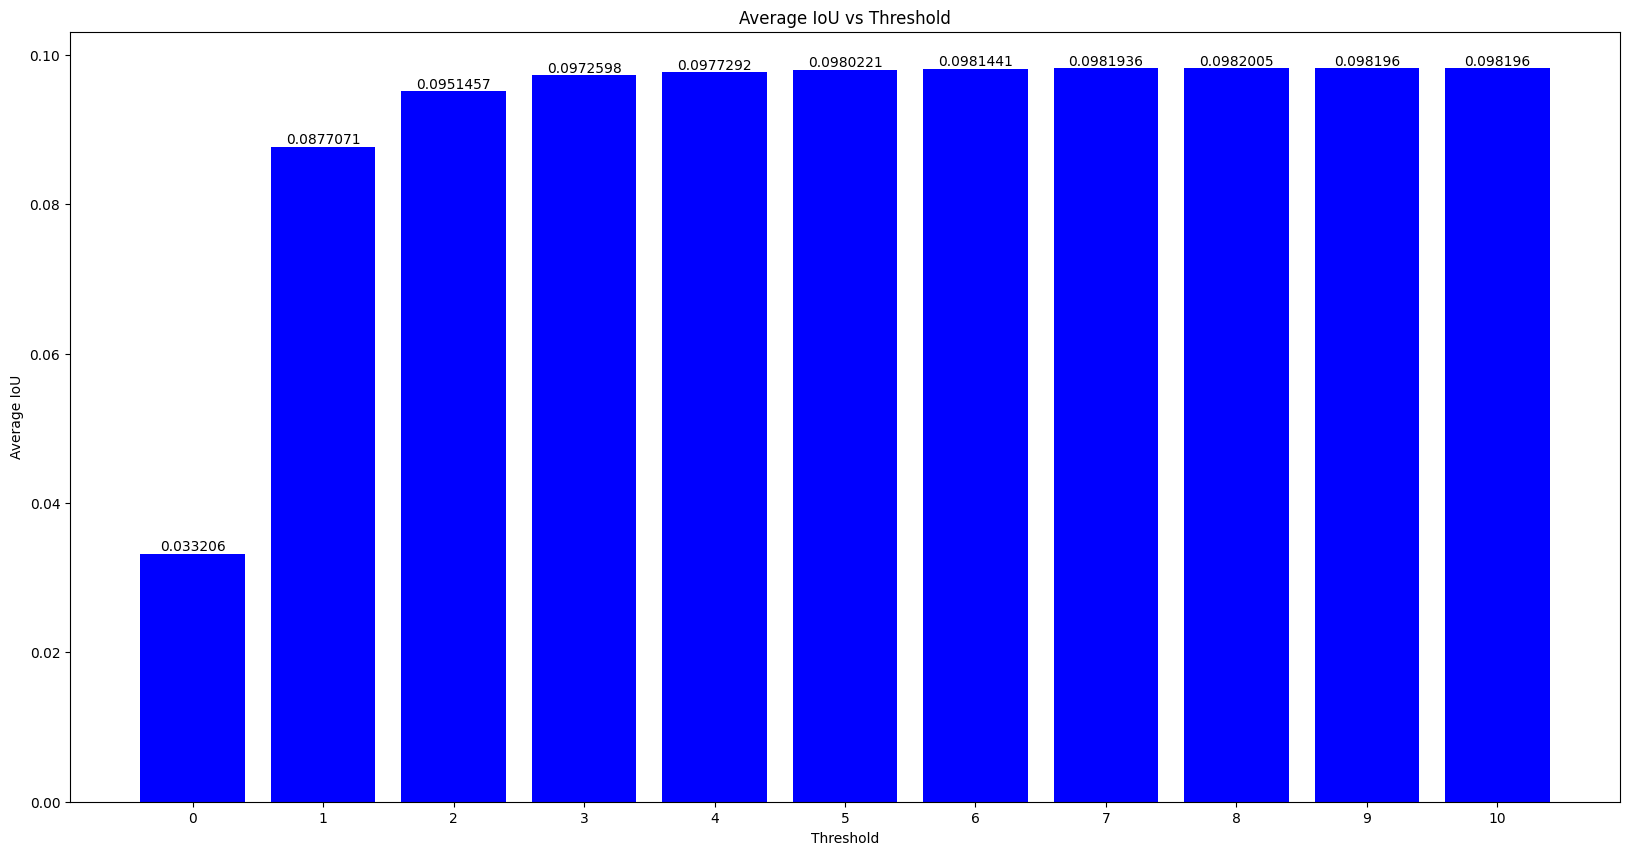

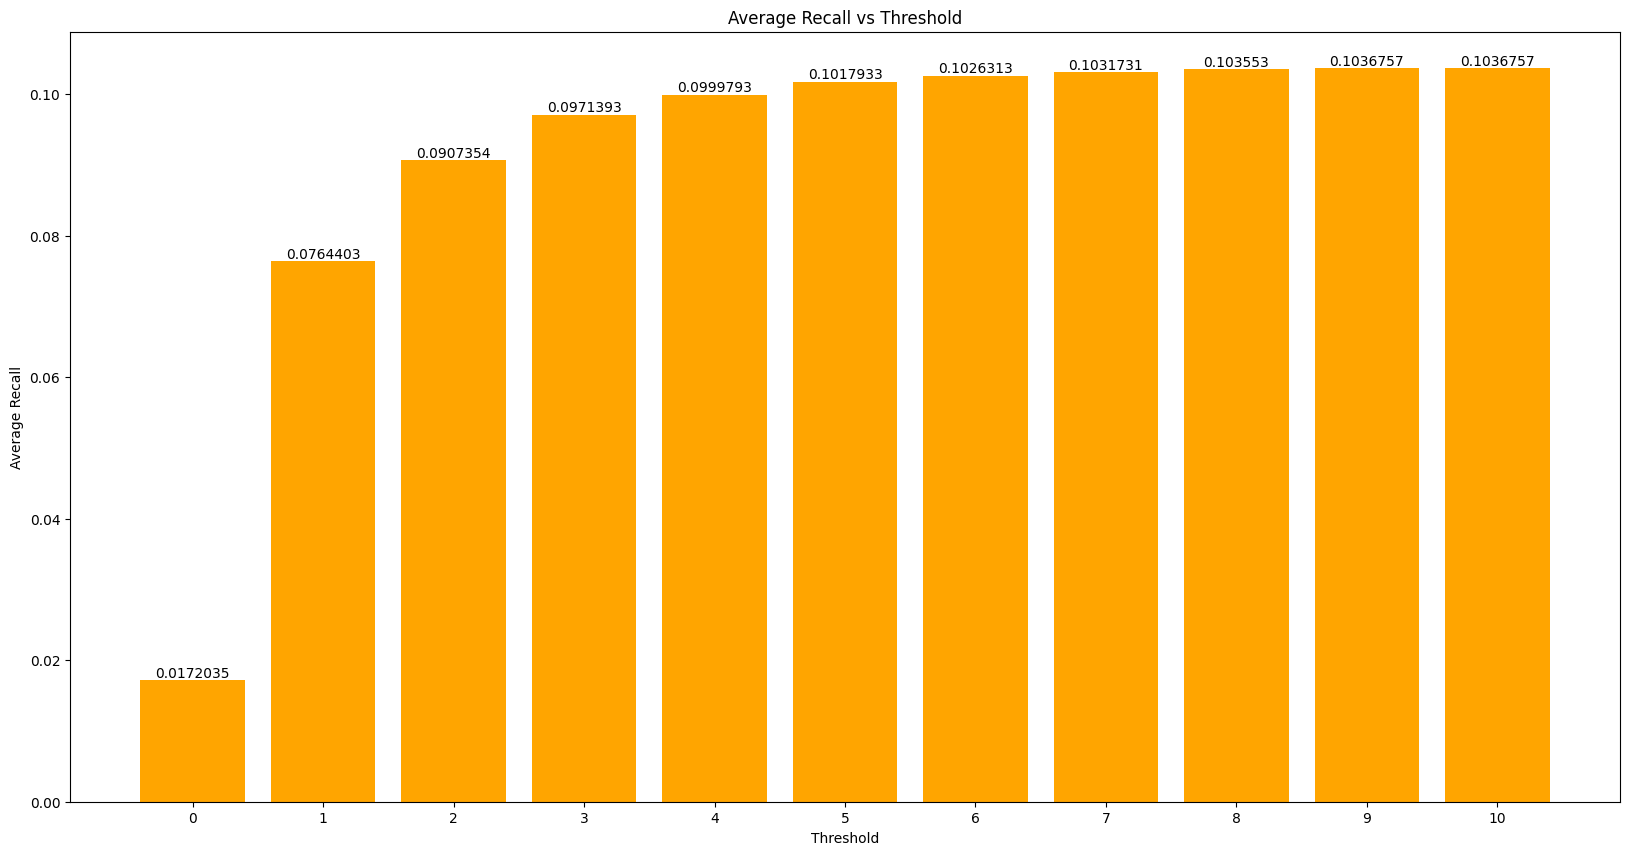

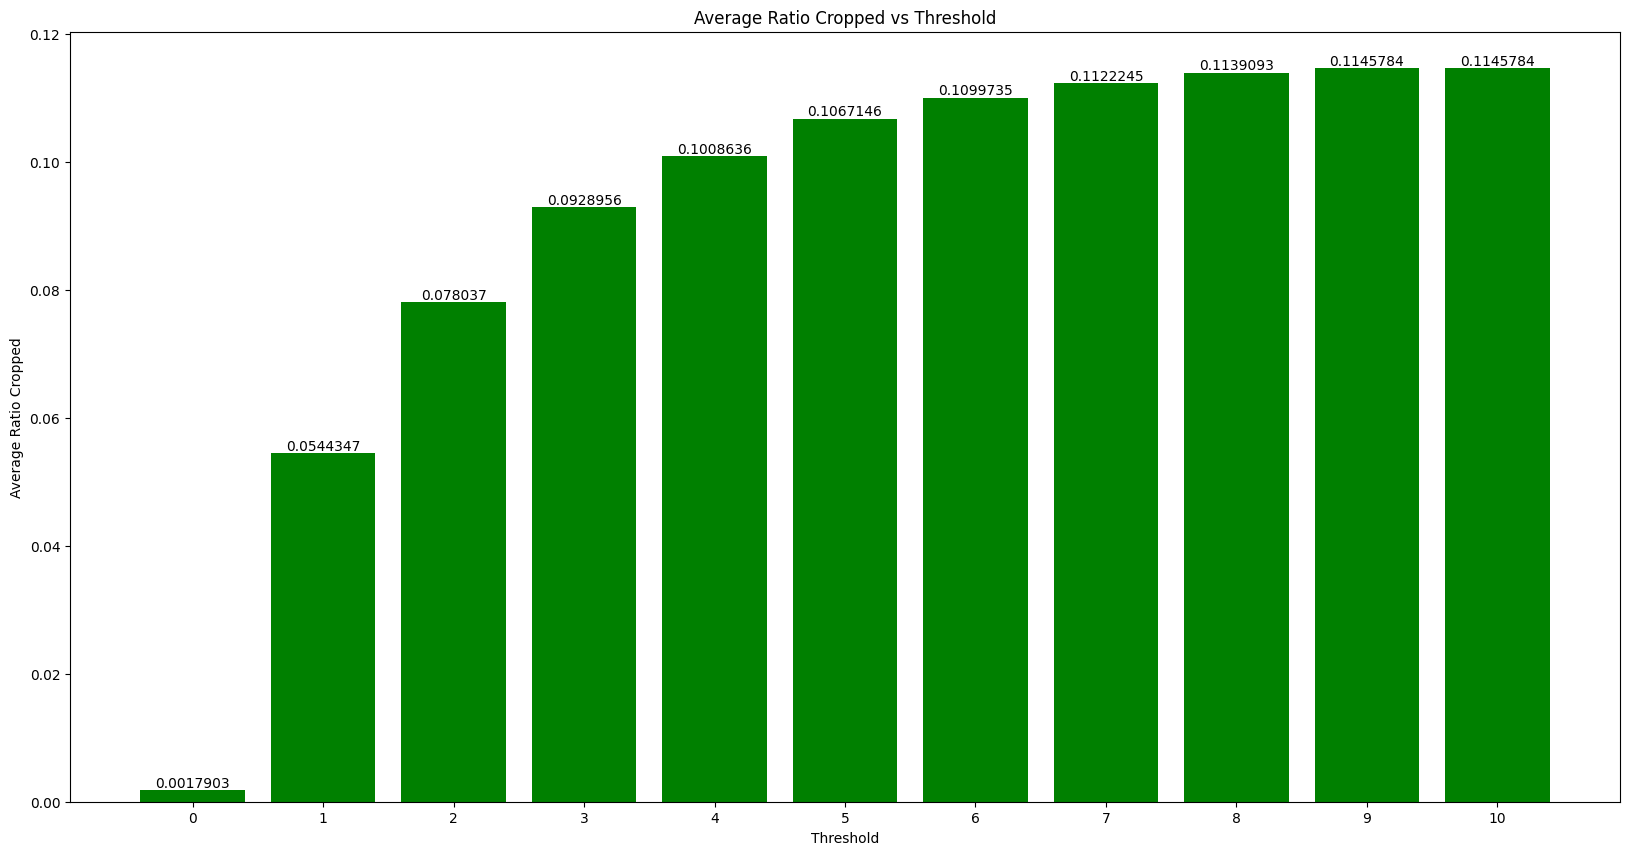

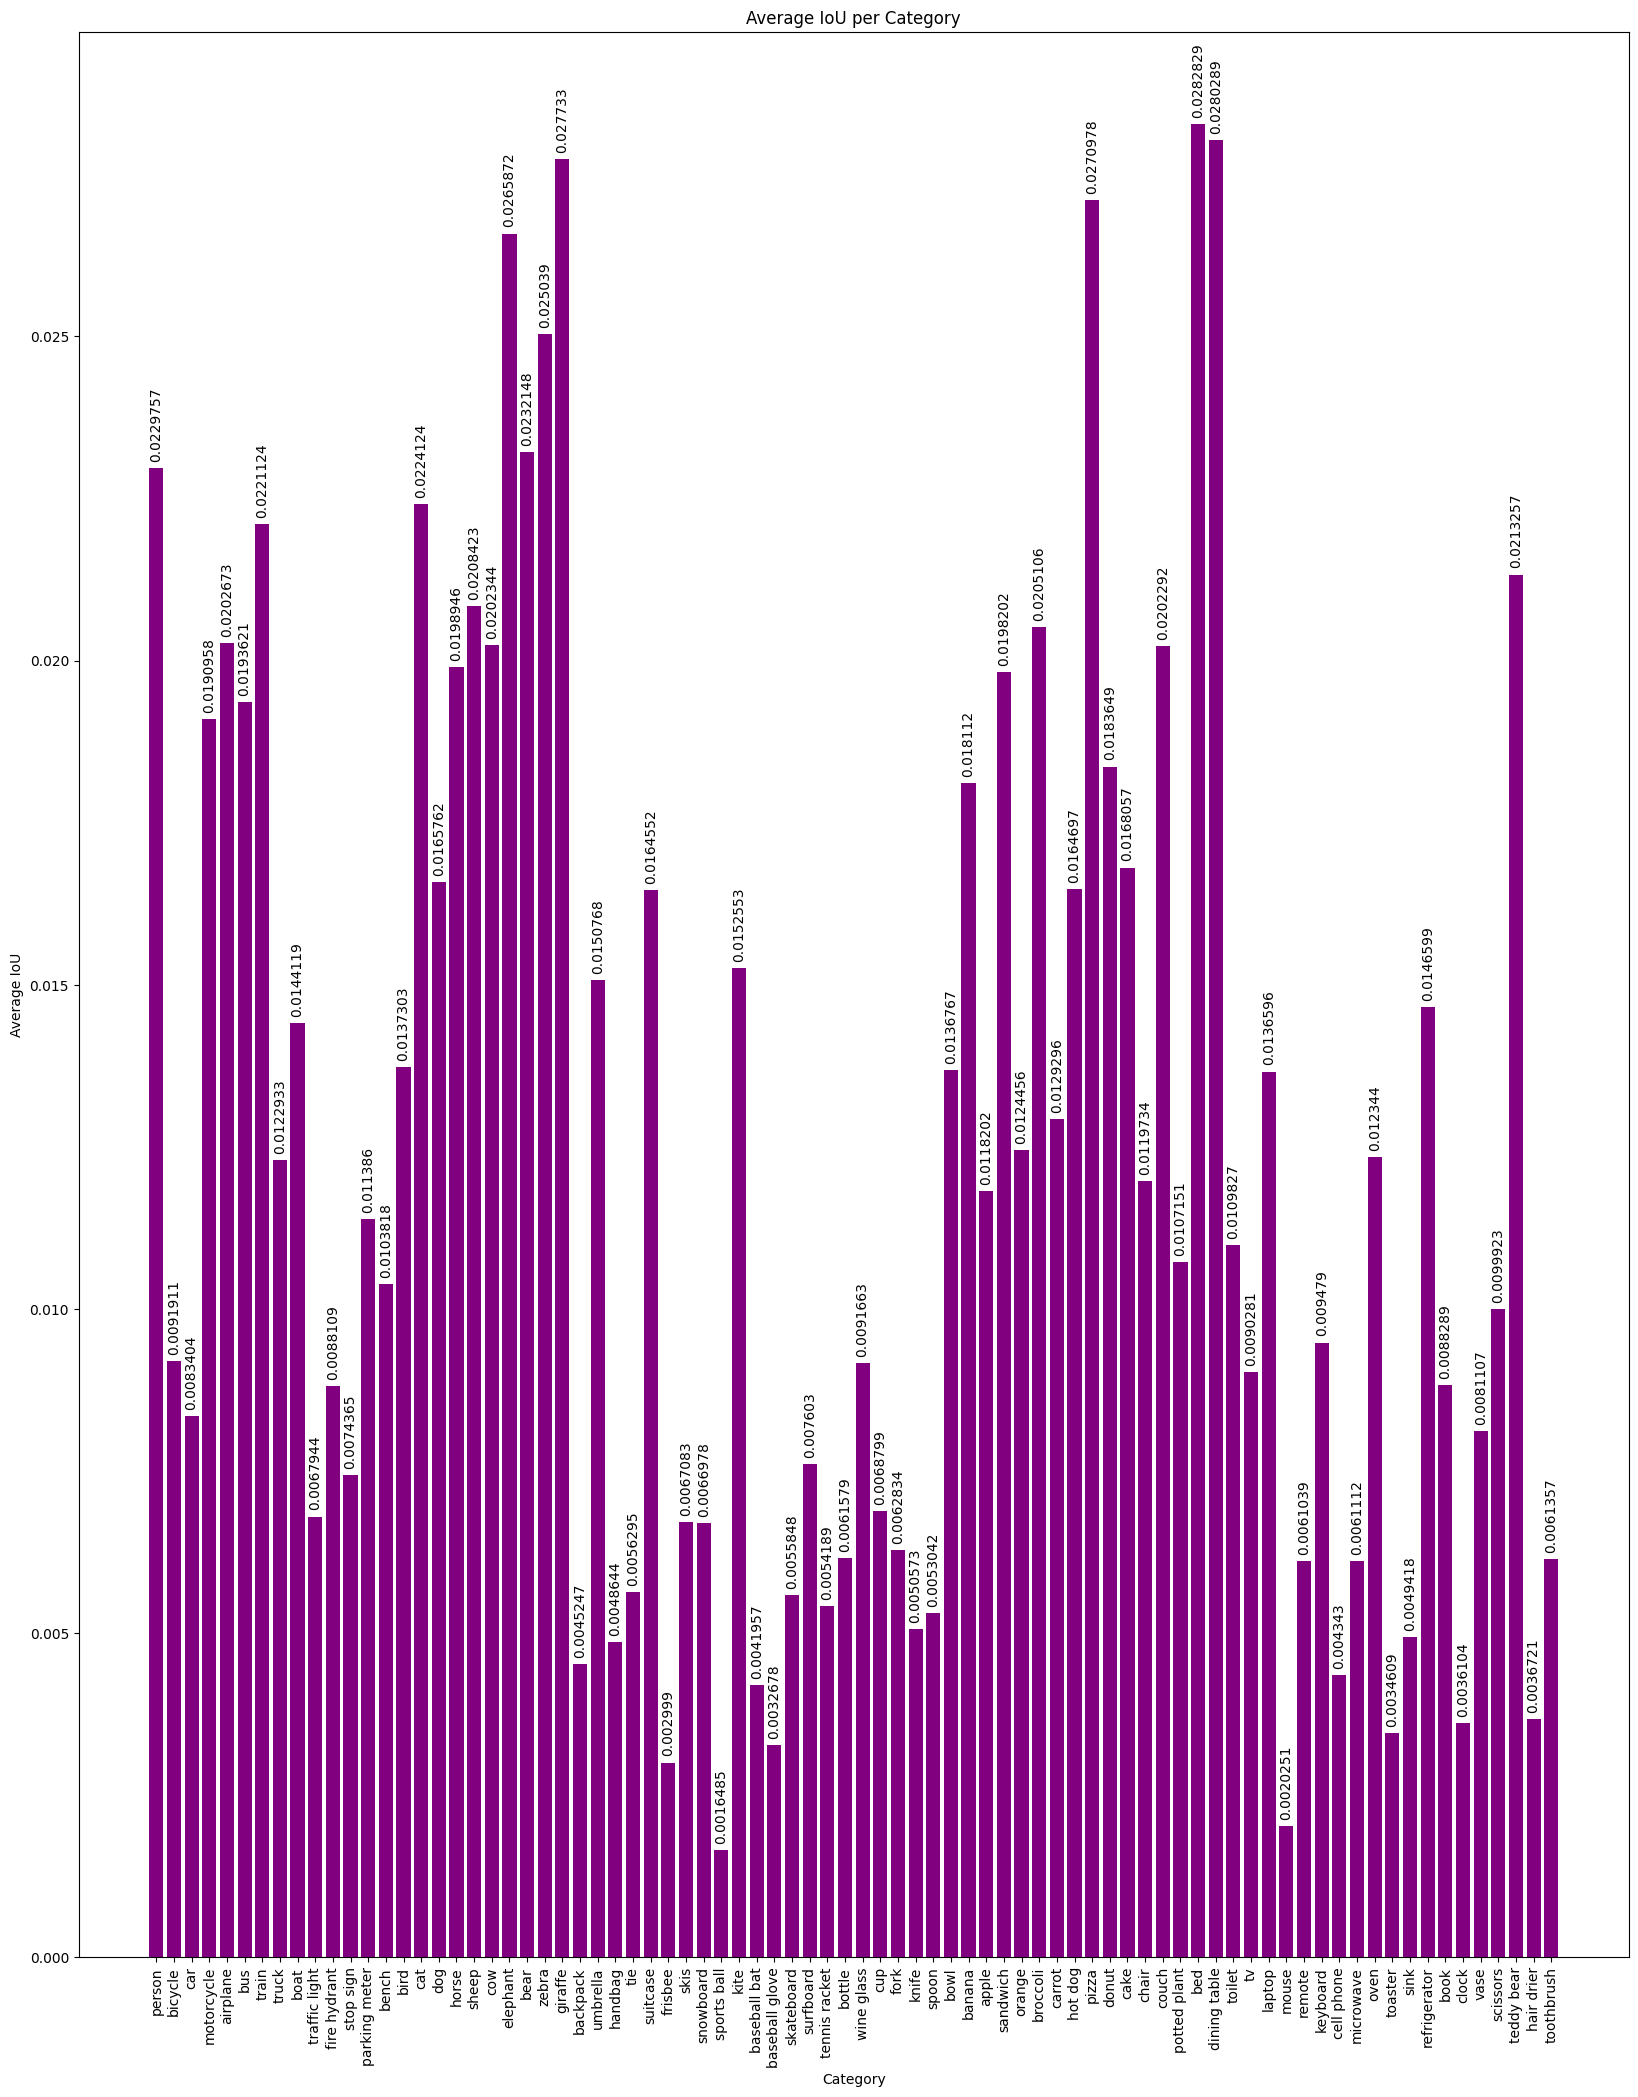

In [51]:
# Loading all the files in the SAVE_PATH in a list of store_dict
store_dict_list = []
for file in os.listdir(SAVE_PATH):
    if file.endswith('.npy'):
        store_dict_list.append(np.load(os.path.join(SAVE_PATH, file), allow_pickle=True).item())

# Calculating the average for all the store_dict in the store_dict_list
avg_stored_dict = {}

# Iterating through all the store_dict in the store_dict_list
for store_dict in store_dict_list:
    # Calculating the average IoU, Recall and Ratio Cropped for the store_dict
    avg_iou = store_dict['Total IoU'] / store_dict['Total Images']

    avg_recall = store_dict['Total Recall'] / store_dict['Total Images']

    avg_ratio_cropped = store_dict['Total Ratio Cropped'] / store_dict['Total Images']

    # Saving the average IoU, Recall and Ratio Cropped to the avg_stored_dict
    avg_stored_dict[store_dict['Threshold']] = {'Total IoU': avg_iou, 'Total Recall': avg_recall, 'Total Ratio Cropped': avg_ratio_cropped}

# Normalising the average IoU, Recall and Ratio Cropped for the avg_stored_dict as probabilities between 0 and 1
sum_avg_iou = sum([avg_stored_dict[key]['Total IoU'] for key in avg_stored_dict.keys()])
sum_avg_recall = sum([avg_stored_dict[key]['Total Recall'] for key in avg_stored_dict.keys()])
sum_avg_ratio_cropped = sum([avg_stored_dict[key]['Total Ratio Cropped'] for key in avg_stored_dict.keys()])
for key in avg_stored_dict.keys():
    avg_stored_dict[key]['Total IoU'] /= sum_avg_iou
    avg_stored_dict[key]['Total Recall'] /= sum_avg_recall
    avg_stored_dict[key]['Total Ratio Cropped'] /= sum_avg_ratio_cropped

# Creating a list for uniform x-axis
x_axis = []
for key in avg_stored_dict.keys():
    x_axis.append(key*10)

# Retrieving the threshold with the highest average IoU
max_iou_threshold = max(avg_stored_dict, key=lambda key: avg_stored_dict[key]['Total IoU'])

print('\033[32m' + 'Threshold with the highest average IoU: ' + '\033[0m' + str(max_iou_threshold))

# Finding the list index of the max_iou_threshold from the store_dict_list
max_iou_threshold_index = 0
for i in range(len(store_dict_list)):
    if store_dict_list[i]['Threshold'] == max_iou_threshold:
        max_iou_threshold_index = i
        break

# Calculating the average Iou for each category for the threshold with the highest average IoU
avg_iou_per_category = {}
for category in store_dict_list[max_iou_threshold_index]['Category'].keys():
    avg_iou_per_category[category] = store_dict_list[max_iou_threshold_index]['Category'][category]['Total IoU'] / store_dict_list[max_iou_threshold_index]['Category'][category]['Total Images']

# Normalising the average IoU for each category such that the sum of the average IoU for each category is 1
sum_avg_iou_per_category = sum(avg_iou_per_category.values())
for category in avg_iou_per_category.keys():
    avg_iou_per_category[category] /= sum_avg_iou_per_category

# Plotting bar graph for the average IoU
plt.figure(figsize=(20,10))
plt.bar(x_axis, [avg_stored_dict[key]['Total IoU'] for key in avg_stored_dict.keys()], color='blue')
# printing text on bar graph
for i in range(len(x_axis)):
    plt.text(x_axis[i], avg_stored_dict[x_axis[i]/10]['Total IoU'], str(round(avg_stored_dict[x_axis[i]/10]['Total IoU'], 7)), ha='center', va='bottom')
plt.title('Average IoU vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Average IoU')
plt.xticks(x_axis)
plt.show()


# Plotting bar graph for the average Recall
plt.figure(figsize=(20,10))
plt.bar(x_axis, [avg_stored_dict[key]['Total Recall'] for key in avg_stored_dict.keys()], color='orange')
# printing text on bar graph
for i in range(len(x_axis)):
    plt.text(x_axis[i], avg_stored_dict[x_axis[i]/10]['Total Recall'], str(round(avg_stored_dict[x_axis[i]/10]['Total Recall'], 7)), ha='center', va='bottom')
plt.title('Average Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Average Recall')
plt.xticks(x_axis)
plt.show()

# Plotting bar graph for the average Ratio Cropped
plt.figure(figsize=(20,10))
plt.bar(x_axis, [avg_stored_dict[key]['Total Ratio Cropped'] for key in avg_stored_dict.keys()], color='green')
# printing text on bar graph
for i in range(len(x_axis)):
    plt.text(x_axis[i], avg_stored_dict[x_axis[i]/10]['Total Ratio Cropped'], str(round(avg_stored_dict[x_axis[i]/10]['Total Ratio Cropped'], 7)), ha='center', va='bottom')
plt.title('Average Ratio Cropped vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Average Ratio Cropped')
plt.xticks(x_axis)
plt.show()

# Plotting bar graph for the average IoU per category
plt.figure(figsize=(20,25))
plt.bar(avg_iou_per_category.keys(), avg_iou_per_category.values(), color='purple')
# printing text on bar graph
y_offset = 0.0001
for i in range(len(avg_iou_per_category)):
    plt.text(list(avg_iou_per_category.keys())[i], list(avg_iou_per_category.values())[i] + y_offset, str(round(list(avg_iou_per_category.values())[i], 7)), ha='center', va='bottom', rotation=90)
plt.title('Average IoU per Category')
plt.xlabel('Category')
plt.ylabel('Average IoU')
plt.xticks(rotation=90)
plt.show()